# Time series analysis from Kaggle Notebook
https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python

In [2]:
import warnings                                  # `do not disturb` mode
warnings.filterwarnings('ignore')

from arch import arch_model
import hvplot as hv
import hvplot.pandas
import matplotlib.pyplot as plt                  # plots
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import seaborn as sns                            # more plots
from dateutil.relativedelta import relativedelta # working with dates with style
from itertools import product                    # some useful functions
from pathlib import Path
import pickle
from pypalettes import load_cmap, add_cmap
from scipy.optimize import minimize              # for function minimization
import scipy.stats as scs
from sklearn.metrics import mean_absolute_percentage_error as mape
import statsmodels.api as sm
import statsmodels.formula.api                   # statistics and econometrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

# Set plot styles
plt.rcParams["figure.figsize"] = [12, 5]
plt.style.use('grayscale')


# Festlegen der Farben
cmap = load_cmap("Apricot")
cmap_continuous = add_cmap(
    colors=["#FFFFFFFF", "#FFF9A1FF", "#BAD09DFF", "#76D3CFFF", "#459E9EFF", "#306677FF", "#24385FFF", "#132157FF"],
    name="apricot_continuous",
    cmap_type="continuous"
)
cmap8 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#005F73FF', '#9093A2FF', '#132157FF'],
    name="apricot8colors",
    cmap_type="discrete"
)
cmap7 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#9093A2FF', '#132157FF'],
    name="apricot7colors",
    cmap_type="discrete"
)


%matplotlib inline



In [40]:
# Load Datasets
df_daily = pd.read_csv('df_daily.csv', usecols=["date", "calls", "days_to_holiday"])
df_hourly = pd.read_csv('df_hourly.csv', usecols=["date", "calls", "days_to_holiday"])
df_daily_test = pd.read_csv('df_daily_2024.csv', usecols=["date", "calls", "days_to_holiday"])
df_hourly_test = pd.read_csv('df_hourly_2024.csv', usecols=["date", "calls", "days_to_holiday"])

# Spalten umbenennen
df_daily = df_daily.rename(columns={"date": "ds", "calls": "y"})
df_daily_test = df_daily_test.rename(columns={"date": "ds", "calls": "y"})
df_hourly = df_hourly.rename(columns={"date": "ds", "calls": "y"})
df_hourly_test = df_hourly_test.rename(columns={"date": "ds", "calls": "y"})

# Sicherstellen, dass ds eine Datetime-Spalte ist
df_daily["ds"] = pd.to_datetime(df_daily["ds"])
df_daily.set_index("ds", inplace=True)

df_hourly["ds"] = pd.to_datetime(df_hourly["ds"])
df_hourly.set_index("ds", inplace=True)

df_daily_test["ds"] = pd.to_datetime(df_daily_test["ds"])
df_daily_test.set_index("ds", inplace=True)

df_hourly_test["ds"] = pd.to_datetime(df_hourly_test["ds"])
df_hourly_test.set_index("ds", inplace=True)

# Slices für Zeiträume ab 2022
df_daily_time_modified = df_daily[df_daily.index >= "2022-01-01"]
df_hourly_time_modified = df_hourly[df_hourly.index >= "2022-01-01"]


In [4]:
df_daily_test

,y,days_to_holiday
ds,,
2024-01-01,211,0
2024-01-02,417,-1
2024-01-03,399,-2
2024-01-04,388,-3
2024-01-05,332,-4
...,...,...
2024-06-26,444,-56
2024-06-27,407,-57
2024-06-28,412,-58


# XGBoost

In [41]:
import pandas as pd

def prepare_xgboost_data(df, lags=7):
    df = df.copy()

    # Sicherstellen, dass die Daten nach Datum sortiert sind
    df = df.sort_values("ds")

    # Lag-Features erstellen
    for lag in range(1, lags + 1):
        df[f"lag_{lag}"] = df["y"].shift(lag)
    
    # Datumsfeatures hinzufügen
    df["weekday"] = df.index.weekday
    df["month"] = df.index.month
    
    # NaN-Werte entfernen (weil die ersten "lags" Zeilen unvollständig sind)
    df = df.dropna()

    return df

# Daten vorbereiten (NUR für das Training)
df_daily_xgb = prepare_xgboost_data(df_daily, lags=7)
df_daily_time_modified_xgb = prepare_xgboost_data(df_daily_time_modified, lags=7)
df_hourly_xgb = prepare_xgboost_data(df_hourly, lags=24)
df_hourly_time_modified_xgb = prepare_xgboost_data(df_hourly_time_modified, lags=24)

In [42]:
# Testdaten vorbereiten
df_daily_test_xgb = prepare_xgboost_data(df_daily_test, lags=7)
df_hourly_test_xgb = prepare_xgboost_data(df_hourly_test, lags=24)

# "ds" für das Modell entfernen (aber später für das Plotten behalten)
X_test_daily = df_daily_test_xgb.drop(columns=["ds", "y", "days_to_holiday"], errors="ignore")
y_test_daily = df_daily_test_xgb["y"]

X_test_hourly = df_hourly_test_xgb.drop(columns=["ds", "y", "days_to_holiday"], errors="ignore")
y_test_hourly = df_hourly_test_xgb["y"]


In [31]:
df_daily_xgb

,y,days_to_holiday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,weekday,month
ds,,,,,,,,,,,
2014-01-08,191.0,-7,225.0,232.0,149.0,192.0,203.0,233.0,153.0,2,1
2014-01-09,167.0,-8,191.0,225.0,232.0,149.0,192.0,203.0,233.0,3,1
2014-01-10,178.0,-9,167.0,191.0,225.0,232.0,149.0,192.0,203.0,4,1
2014-01-11,129.0,-10,178.0,167.0,191.0,225.0,232.0,149.0,192.0,5,1
2014-01-12,131.0,-11,129.0,178.0,167.0,191.0,225.0,232.0,149.0,6,1
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,405.0,-2,485.0,325.0,244.0,263.0,339.0,346.0,391.0,2,12
2023-12-28,372.0,-3,405.0,485.0,325.0,244.0,263.0,339.0,346.0,3,12
2023-12-29,363.0,3,372.0,405.0,485.0,325.0,244.0,263.0,339.0,4,12


In [54]:
import xgboost as xgb
import pandas as pd

def make_prediction(train_df, test_df, X_test):
    """Trainiert ein XGBoost-Modell und macht eine Vorhersage."""
    # Features und Zielvariable für das Training
    X_train = train_df.drop(columns=["y"])
    y_train = train_df["y"]
    
    # Features und Zielvariable für den Test
    X_test = test_df.drop(columns=["y"])
    y_test = test_df["y"]
    
    # Modell trainieren
    model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
    model.fit(X_train, y_train)
    
    # Vorhersage
    y_pred = model.predict(X_test)
    
    return y_test, y_pred

# 📌 Vorhersage für df_daily_test mit df_daily & df_daily_time_modified
y_test_daily, y_pred_daily = make_prediction(df_daily_xgb, df_daily_test_xgb, X_test_daily)
y_test_daily_mod, y_pred_daily_mod = make_prediction(df_daily_time_modified_xgb, df_daily_test_xgb, X_test_daily)

# 📌 Vorhersage für df_hourly_test mit df_hourly & df_hourly_time_modified
y_test_hourly, y_pred_hourly = make_prediction(df_hourly_xgb, df_hourly_test_xgb, X_test_hourly)
y_test_hourly_mod, y_pred_hourly_mod = make_prediction(df_hourly_time_modified_xgb, df_hourly_test_xgb, X_test_hourly)


In [49]:
# Beste Hyperparameter aus Optuna
best_params_daily = {
    'n_estimators': 250,
    'max_depth': 4,
    'learning_rate': 0.0345499044056765,
    'subsample': 0.7009908933388722,
    'colsample_bytree': 0.8972255378594777,
    'reg_alpha': 9.062327214411307e-05,
    'reg_lambda': 0.040743993041993214
}

def make_prediction_daily_hpo(train_df, test_df, X_test):
    """Trainiert ein XGBoost-Modell und macht eine Vorhersage."""
    # Features und Zielvariable für das Training
    X_train = train_df.drop(columns=["y"])
    y_train = train_df["y"]
    
    # Features und Zielvariable für den Test
    X_test = test_df.drop(columns=["y"])
    y_test = test_df["y"]
    
    # Modell trainieren
    model = xgb.XGBRegressor(objective="reg:squarederror", **best_params_daily)
    model.fit(X_train, y_train)
    
    # Vorhersage
    y_pred = model.predict(X_test)
    
    return y_test, y_pred

# 📌 Vorhersage für df_daily_test mit df_daily & df_daily_time_modified
y_test_daily_hpo, y_pred_daily_hpo = make_prediction(df_daily_xgb, df_daily_test_xgb, X_test_daily)
y_test_daily_mod_hpo, y_pred_daily_mod_hpo = make_prediction(df_daily_time_modified_xgb, df_daily_test_xgb, X_test_daily)

In [62]:
# Beste Hyperparameter aus Optuna
best_params_hourly = {
    'n_estimators': 465,
    'max_depth': 7,
    'learning_rate': 0.016455386512152618,
    'subsample': 0.7230362971337, 
    'colsample_bytree': 0.7305886295207178, 
    'reg_alpha': 0.20989392564868328, 
    'reg_lambda': 6.546573193868861e-05

}

def make_prediction_daily_hpo(train_df, test_df, X_test):
    """Trainiert ein XGBoost-Modell und macht eine Vorhersage."""
    # Features und Zielvariable für das Training
    X_train = train_df.drop(columns=["y"])
    y_train = train_df["y"]
    
    # Features und Zielvariable für den Test
    X_test = test_df.drop(columns=["y"])
    y_test = test_df["y"]
    
    # Modell trainieren
    model = xgb.XGBRegressor(objective="reg:squarederror", **best_params_hourly)
    model.fit(X_train, y_train)
    
    # Vorhersage
    y_pred = model.predict(X_test)
    
    return y_test, y_pred

# 📌 Vorhersage für df_hourly_test mit df_hourly & df_hourly_time_modified
y_test_hourly_hpo, y_pred_hourly_hpo = make_prediction(df_hourly_xgb, df_hourly_test_xgb, X_test_hourly)
y_test_hourly_mod_hpo, y_pred_hourly_mod_hpo = make_prediction(df_hourly_time_modified_xgb, df_hourly_test_xgb, X_test_hourly)

In [55]:
df_daily_test = df_daily_test.iloc[-len(y_pred_daily):]

y_pred_daily = pd.Series(y_pred_daily, index=df_daily_test.index)
y_pred_daily_mod = pd.Series(y_pred_daily_mod, index=df_daily_test.index)


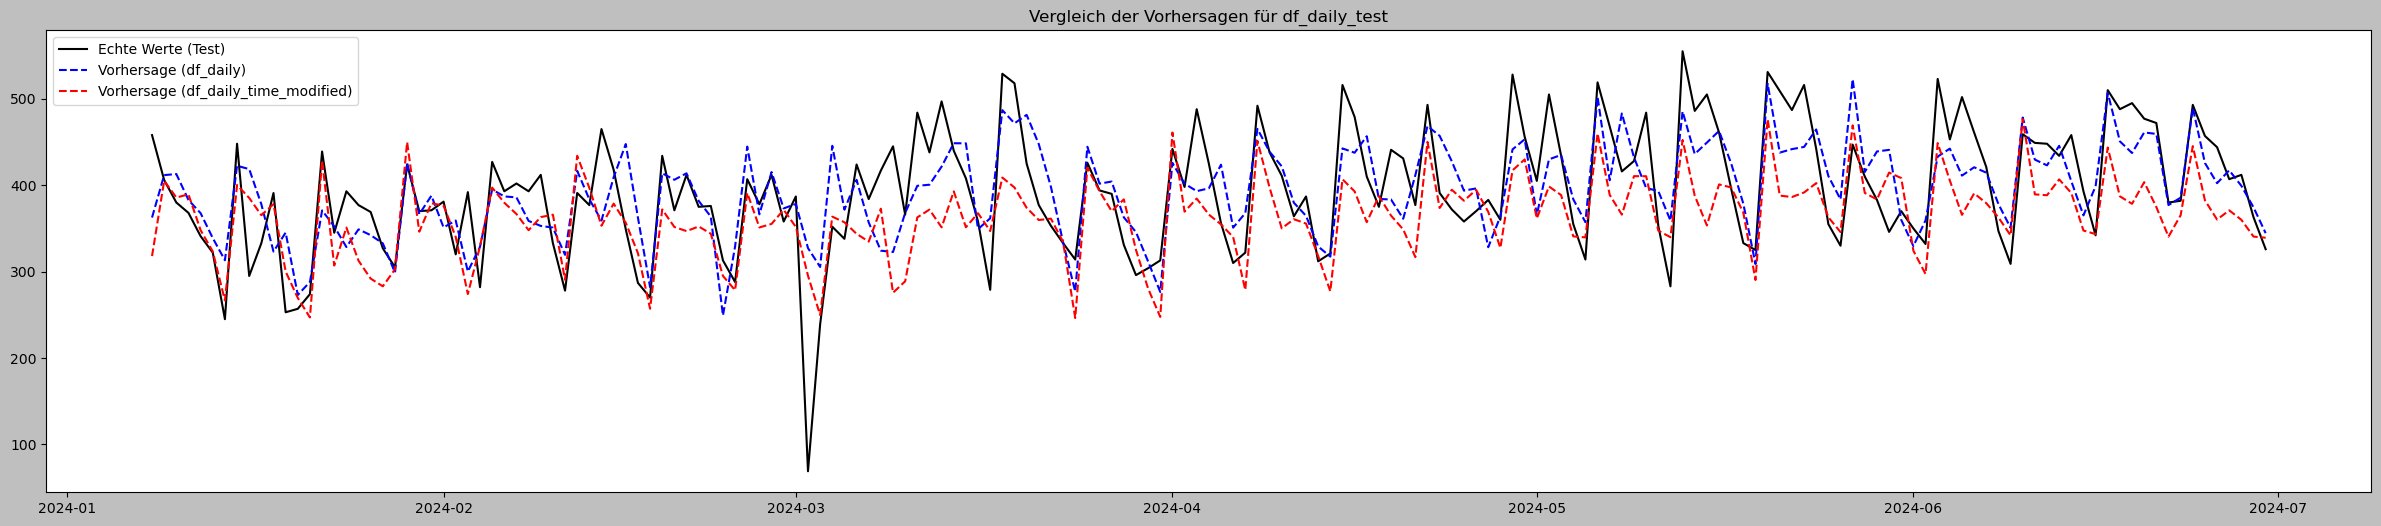

In [56]:
plt.figure(figsize=(30, 6))
plt.plot(df_daily_test.index, df_daily_test["y"], label="Echte Werte (Test)", color="black")
plt.plot(df_daily_test.index, y_pred_daily, label="Vorhersage (df_daily)", linestyle="dashed", color="blue")
plt.plot(df_daily_test.index, y_pred_daily_mod, label="Vorhersage (df_daily_time_modified)", linestyle="dashed", color="red")
plt.legend()
plt.title("Vergleich der Vorhersagen für df_daily_test")
plt.show()

In [52]:
df_daily_test_hpo = df_daily_test.iloc[-len(y_pred_daily_hpo):]

y_pred_daily_hpo = pd.Series(y_pred_daily_hpo, index=df_daily_test_hpo.index)
y_pred_daily_mod_hpo = pd.Series(y_pred_daily_mod_hpo, index=df_daily_test_hpo.index)

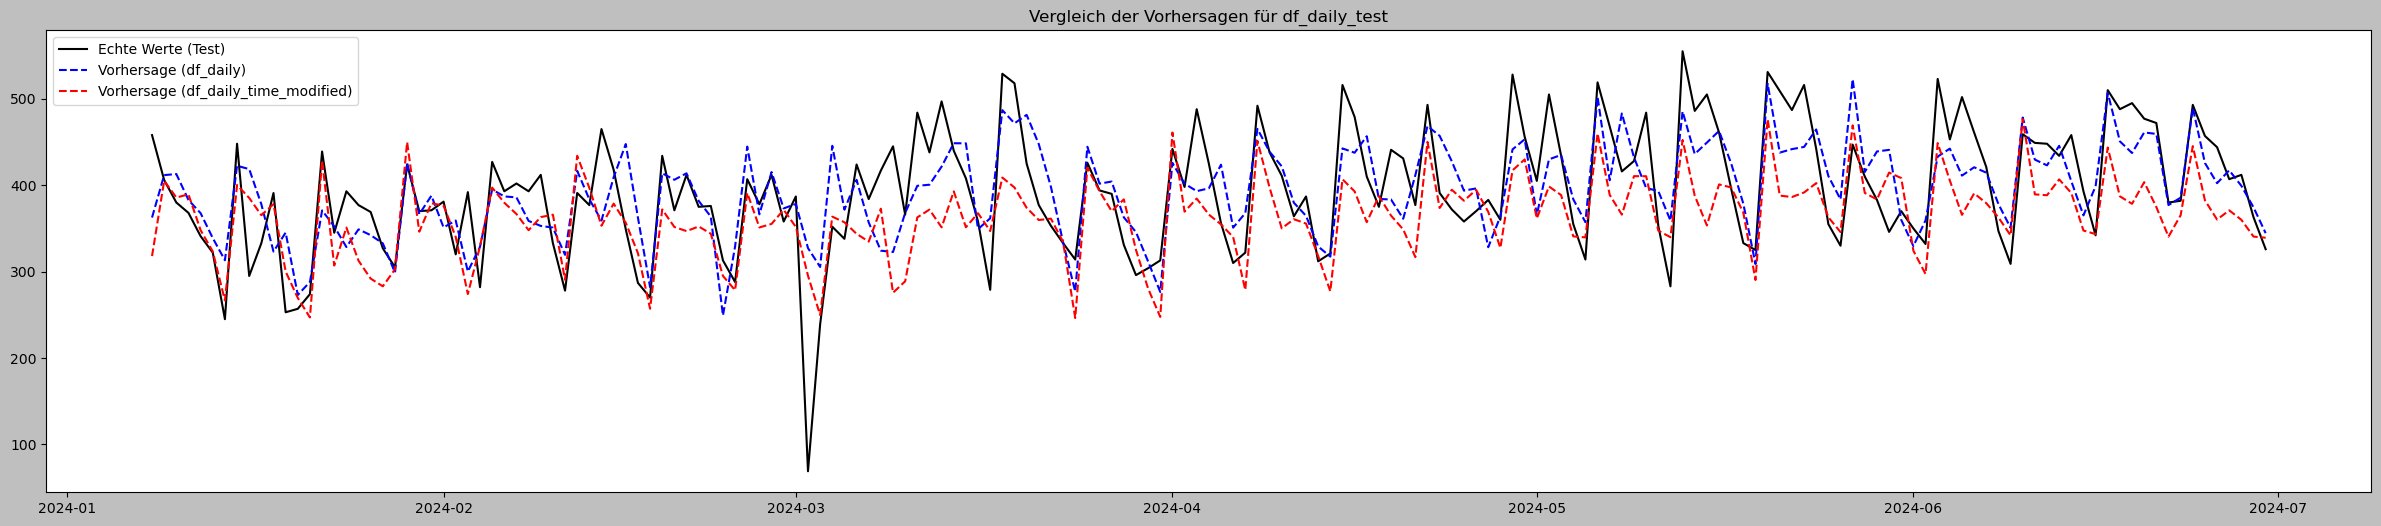

In [ ]:
plt.figure(figsize=(30, 6))
plt.plot(df_daily_test_hpo.index, df_daily_test_hpo["y"], label="Echte Werte (Test)", color="black")
plt.plot(df_daily_test_hpo.index, y_pred_daily_hpo, label="Vorhersage (df_daily)", linestyle="dashed", color="blue")
plt.plot(df_daily_test_hpo.index, y_pred_daily_mod_hpo, label="Vorhersage (df_daily_time_modified)", linestyle="dashed", color="red")
plt.legend()
plt.title("Vergleich der Vorhersagen für df_daily_test_hpo")
plt.show()

In [58]:
df_hourly_test = df_hourly_test.iloc[-len(y_pred_hourly):]
y_pred_hourly = pd.Series(y_pred_hourly, index=df_hourly_test.index)
y_pred_hourly_mod = pd.Series(y_pred_hourly_mod, index=df_hourly_test.index)

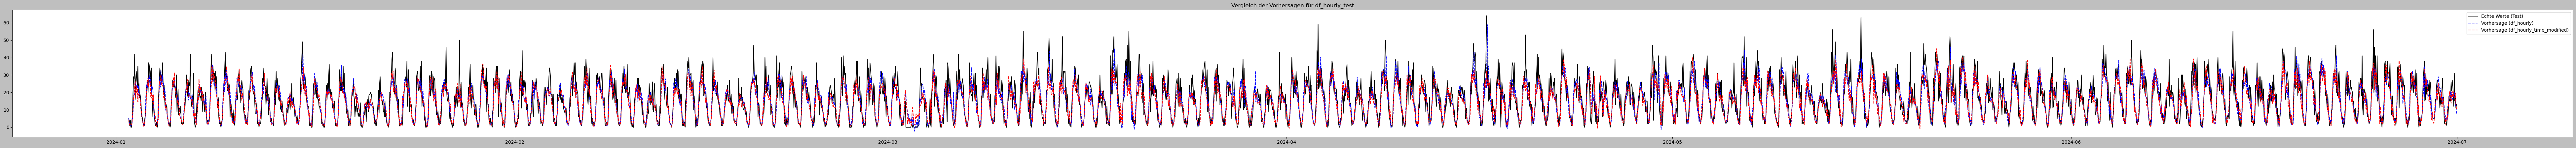

In [12]:
plt.figure(figsize=(100, 5))
plt.plot(df_hourly_test.index, df_hourly_test["y"], label="Echte Werte (Test)", color="black")
plt.plot(df_hourly_test.index, y_pred_hourly, label="Vorhersage (df_hourly)", linestyle="dashed", color="blue")
plt.plot(df_hourly_test.index, y_pred_hourly_mod, label="Vorhersage (df_hourly_time_modified)", linestyle="dashed", color="red")
plt.legend()
plt.title("Vergleich der Vorhersagen für df_hourly_test")
plt.show()

In [63]:
df_hourly_test_hpo = df_hourly_test.iloc[-len(y_pred_hourly_hpo):]
y_pred_hourly_hpo = pd.Series(y_pred_hourly_hpo, index=df_hourly_test_hpo.index)
y_pred_hourly_mod_hpo = pd.Series(y_pred_hourly_mod_hpo, index=df_hourly_test_hpo.index)

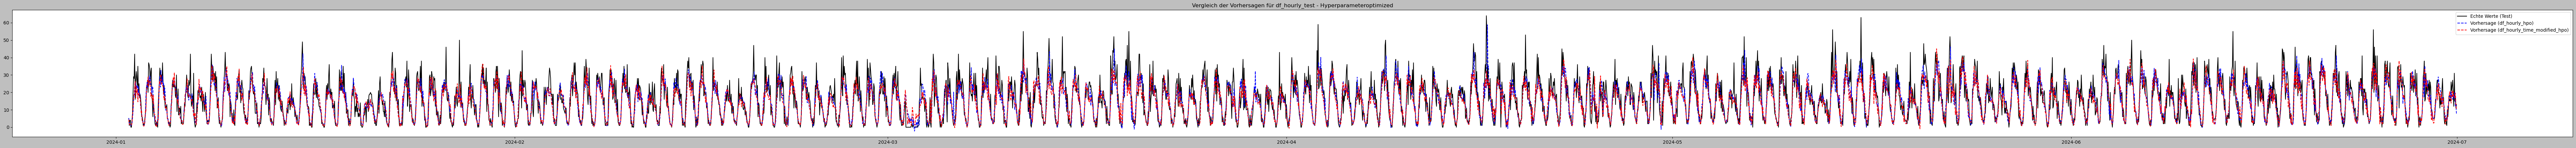

In [64]:
plt.figure(figsize=(100, 5))
plt.plot(df_hourly_test.index, df_hourly_test["y"], label="Echte Werte (Test)", color="black")
plt.plot(df_hourly_test.index, y_pred_hourly_hpo, label="Vorhersage (df_hourly_hpo)", linestyle="dashed", color="blue")
plt.plot(df_hourly_test.index, y_pred_hourly_mod_hpo, label="Vorhersage (df_hourly_time_modified_hpo)", linestyle="dashed", color="red")
plt.legend()
plt.title("Vergleich der Vorhersagen für df_hourly_test - Hyperparameteroptimized")
plt.show()

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"🔹 {model_name}")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.2f}")
    print("-" * 30)

evaluate_model(df_daily_test["y"], y_pred_daily, "XGBoost - df_daily")
evaluate_model(df_daily_test["y"], y_pred_daily_mod, "XGBoost - df_daily_time_modified")
evaluate_model(df_daily_test["y"], y_pred_daily_hpo, "XGBoost - df_daily - Hyperparameteroptimized")
evaluate_model(df_daily_test["y"], y_pred_daily_mod_hpo, "XGBoost - df_daily_time_modified - Hyperparameteroptimized")

evaluate_model(df_hourly_test["y"], y_pred_hourly, "XGBoost - df_hourly")
evaluate_model(df_hourly_test["y"], y_pred_hourly_mod, "XGBoost - df_hourly_time_modified")

🔹 XGBoost - df_daily
MAE:  38.29
RMSE: 50.64
R²:   0.51
------------------------------
🔹 XGBoost - df_daily_time_modified
MAE:  46.97
RMSE: 60.57
R²:   0.30
------------------------------
🔹 XGBoost - df_daily - Hyperparameteroptimized
MAE:  38.29
RMSE: 50.64
R²:   0.51
------------------------------
🔹 XGBoost - df_daily_time_modified - Hyperparameteroptimized
MAE:  46.97
RMSE: 60.57
R²:   0.30
------------------------------
🔹 XGBoost - df_hourly
MAE:  4.67
RMSE: 6.49
R²:   0.66
------------------------------
🔹 XGBoost - df_hourly_time_modified
MAE:  4.78
RMSE: 6.62
R²:   0.65
------------------------------


In [24]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# 🎯 Optuna-Ziel: MSE minimieren
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-5, 10),
    }

    # X_train und y_train aus den bereits vorbereiteten DataFrames entnehmen
    X_train = df_daily_xgb.drop(columns=["y"])
    y_train = df_daily_xgb["y"]
    X_test = df_daily_test_xgb.drop(columns=["y"])
    y_test = df_daily_test_xgb["y"]

    # Trainiere das Modell mit den getesteten Hyperparametern
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    # Mache Vorhersagen und berechne den MSE
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

# 🎯 Starte die Optimierung mit 50 Versuchen (mehr = bessere Ergebnisse, aber langsamer)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Beste gefundene Hyperparameter ausgeben
best_params = study.best_params
print("Beste Hyperparameter:", best_params)


[I 2025-02-24 14:03:18,537] A new study created in memory with name: no-name-b91fe6d6-aff1-464e-8d8f-4fbe77815697
C:\Users\ChiaraVogt\AppData\Local\Temp\ipykernel_9468\1900644185.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\ChiaraVogt\AppData\Local\Temp\ipykernel_9468\1900644185.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\ChiaraVogt\AppData\Local\Temp\ipykernel_9468\1900644185.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github

Beste Hyperparameter: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.0345499044056765, 'subsample': 0.7009908933388722, 'colsample_bytree': 0.8972255378594777, 'reg_alpha': 9.062327214411307e-05, 'reg_lambda': 0.040743993041993214}


In [61]:
# 🎯 Optuna-Ziel: MSE minimieren
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-5, 10),
    }

    # X_train und y_train aus den bereits vorbereiteten DataFrames entnehmen
    X_train = df_hourly_xgb.drop(columns=["y"])
    y_train = df_hourly_xgb["y"]
    X_test = df_hourly_test_xgb.drop(columns=["y"])
    y_test = df_hourly_test_xgb["y"]

    # Trainiere das Modell mit den getesteten Hyperparametern
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    # Mache Vorhersagen und berechne den MSE
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

# 🎯 Starte die Optimierung mit 50 Versuchen (mehr = bessere Ergebnisse, aber langsamer)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Beste gefundene Hyperparameter ausgeben
best_params = study.best_params
print("Beste Hyperparameter für hourly:", best_params)

[I 2025-02-24 15:01:19,573] A new study created in memory with name: no-name-12bfb305-543d-41fd-be04-f6b195cbe20e
C:\Users\ChiaraVogt\AppData\Local\Temp\ipykernel_9468\3640362445.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\ChiaraVogt\AppData\Local\Temp\ipykernel_9468\3640362445.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\ChiaraVogt\AppData\Local\Temp\ipykernel_9468\3640362445.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.

Beste Hyperparameter für hourly: {'n_estimators': 465, 'max_depth': 7, 'learning_rate': 0.016455386512152618, 'subsample': 0.7230362971337, 'colsample_bytree': 0.7305886295207178, 'reg_alpha': 0.20989392564868328, 'reg_lambda': 6.546573193868861e-05}
